# Pipeline

### Data input

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Importing the dataset
df = pd.read_csv('data/creditcard.csv')
df = df.drop(['Time'], axis=1)
df.reset_index(drop=True, inplace=True)

KeyboardInterrupt: 

### Data preprocessing

### Model hyperparameter tuning

In [44]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer 

pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(),
    LogisticRegression()
)

params_grid = {
    'selectkbest__k': [5, 15, 25],
    'logisticregression__C': [ 0.1, 1, 5],
    'logisticregression__solver': ['lbfgs', 'liblinear'],
}

As the data set in really unbalanced, we will use the F1 score as the metric to evaluate the model performance.

In [46]:
from sklearn.model_selection import train_test_split
f1_score_list_lg = []
k=5

# Split data
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis=1), df['Class'], test_size=0.2)

# Train model
grid = GridSearchCV(pipeline, param_grid=params_grid, cv=4, scoring="f1", verbose=3)
grid.fit(X_train, y_train)
model = grid.best_estimator_

for _ in range(k):
    # Evaluate model
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis=1), df['Class'], test_size=0.2)
    model.fit(X_train, y_train)
    y_pred = pd.DataFrame(model.predict_proba(X_test)[:,-1] > 0.2)
    y_test = pd.DataFrame(y_test)
    f1_score_list_lg.append(f1_score(y_test, y_pred))

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.658 total time=   0.5s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.704 total time=   0.5s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.649 total time=   0.5s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.704 total time=   0.4s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.675 total time=   0.8s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.759 total time=   0.7s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.679 total time=   0.7s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=l

c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.680 total time=   1.5s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.724 total time=   1.3s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.708 total time=   1.3s


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.692 total time=   1.6s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.658 total time=   0.5s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.708 total time=   0.5s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.636 total time=   0.6s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.688 total time=   0.5s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.667 total time=   0.9s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.736 total time=   0.9s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0

c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.675 total time=   1.4s


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.727 total time=   1.5s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.728 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.692 total time=   1.5s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.658 total time=   0.5s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.704 total time=   0.6s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.649 total time=   0.6s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.704 total time=   0.5s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.675 total time=   1.0s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.766 total time=   1.2s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.679 total time=

c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.675 total time=   1.4s


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.735 total time=   1.5s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.728 total time=   1.3s


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.692 total time=   1.5s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.658 total time=   0.7s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.704 total time=   0.6s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.649 total time=   0.5s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.704 total time=   0.6s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.671 total time=   1.1s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.774 total time=   1.3s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.688 total time=

In [49]:
print(f"The average f1 score for {k} LogisticRegression is: {sum(f1_score_list_lg)/k}, with the following parameters:\n {grid.best_params_}")

The average f1 score for 5 LogisticRegression is: 0.7801885253330916, with the following parameters:
 {'logisticregression__C': 1, 'logisticregression__solver': 'liblinear', 'selectkbest__k': 15}


For LogisticRegression, we manage to have an average f1 score of 0.78 for 5 differents train/test splits. We take 0.2 as the threshold of the model, to better recognize the fraud.

In [52]:
import xgboost as xgb

pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(),
    xgb.XGBClassifier(early_stopping_rounds=2, tree_method='hist')
)

params_grid = {
    'selectkbest__k': [5, 15, 25],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.05],
}

In [55]:
# Split data
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
train, validation = train_test_split(train, test_size=0.2)
Dtrain = xgb.DMatrix(train.drop(['Class'], axis=1), label=train['Class'])
Dval = xgb.DMatrix(validation.drop(['Class'], axis=1), label=validation['Class'])
Dtest = xgb.DMatrix(test.drop(['Class'], axis=1), label=test['Class'])

search_cv = []

for eta in [0.05, 0.1, 0.5]:
    for mdepth in [3, 7]:
        for tree_method in ['hist', 'approx', 'auto']:
            for threshold in [0.2, 0.3, 0.4, 0.5]:
                # Train model
                param = {
                    'max_depth': mdepth,
                    'eta': eta,
                    'objective': 'binary:logistic',
                    'tree_method': tree_method,
                }

                # Evaluate model
                num_round = 100
                eval_list = [(Dval, 'eval'), (Dtrain, 'train')]
                bst = xgb.train(param, Dtrain, num_round, eval_list, early_stopping_rounds=5, verbose_eval=10)

                # Model evaluation
                y_pred = pd.DataFrame(bst.predict(Dval) > threshold)
                y_val = pd.DataFrame(validation['Class'])
                f1_score(y_val, y_pred)
                search_cv.append([param, f1_score(y_val, y_pred), threshold])

c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64452	train-logloss:0.64451
[10]	eval-logloss:0.33755	train-logloss:0.33745
[20]	eval-logloss:0.19091	train-logloss:0.19075
[30]	eval-logloss:0.11201	train-logloss:0.11177
[40]	eval-logloss:0.06722	train-logloss:0.06693
[50]	eval-logloss:0.04111	train-logloss:0.04077
[60]	eval-logloss:0.02567	train-logloss:0.02528
[70]	eval-logloss:0.01647	train-logloss:0.01604
[80]	eval-logloss:0.01097	train-logloss:0.01049
[90]	eval-logloss:0.00769	train-logloss:0.00716
[99]	eval-logloss:0.00588	train-logloss:0.00530
[0]	eval-logloss:0.64452	train-logloss:0.64451
[10]	eval-logloss:0.33755	train-logloss:0.33745


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.19091	train-logloss:0.19075
[30]	eval-logloss:0.11201	train-logloss:0.11177
[40]	eval-logloss:0.06722	train-logloss:0.06693
[50]	eval-logloss:0.04111	train-logloss:0.04077
[60]	eval-logloss:0.02567	train-logloss:0.02528
[70]	eval-logloss:0.01647	train-logloss:0.01604
[80]	eval-logloss:0.01097	train-logloss:0.01049
[90]	eval-logloss:0.00769	train-logloss:0.00716
[99]	eval-logloss:0.00588	train-logloss:0.00530
[0]	eval-logloss:0.64452	train-logloss:0.64451
[10]	eval-logloss:0.33755	train-logloss:0.33745


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.19091	train-logloss:0.19075
[30]	eval-logloss:0.11201	train-logloss:0.11177
[40]	eval-logloss:0.06722	train-logloss:0.06693
[50]	eval-logloss:0.04111	train-logloss:0.04077
[60]	eval-logloss:0.02567	train-logloss:0.02528
[70]	eval-logloss:0.01647	train-logloss:0.01604
[80]	eval-logloss:0.01097	train-logloss:0.01049
[90]	eval-logloss:0.00769	train-logloss:0.00716
[99]	eval-logloss:0.00588	train-logloss:0.00530
[0]	eval-logloss:0.64452	train-logloss:0.64451


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33755	train-logloss:0.33745
[20]	eval-logloss:0.19091	train-logloss:0.19075
[30]	eval-logloss:0.11201	train-logloss:0.11177
[40]	eval-logloss:0.06722	train-logloss:0.06693
[50]	eval-logloss:0.04111	train-logloss:0.04077
[60]	eval-logloss:0.02567	train-logloss:0.02528
[70]	eval-logloss:0.01647	train-logloss:0.01604
[80]	eval-logloss:0.01097	train-logloss:0.01049
[90]	eval-logloss:0.00769	train-logloss:0.00716
[99]	eval-logloss:0.00588	train-logloss:0.00530


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64452	train-logloss:0.64451
[10]	eval-logloss:0.33755	train-logloss:0.33744
[20]	eval-logloss:0.19092	train-logloss:0.19074
[30]	eval-logloss:0.11201	train-logloss:0.11176
[40]	eval-logloss:0.06718	train-logloss:0.06688
[50]	eval-logloss:0.04102	train-logloss:0.04069
[60]	eval-logloss:0.02555	train-logloss:0.02518
[70]	eval-logloss:0.01634	train-logloss:0.01592
[80]	eval-logloss:0.01085	train-logloss:0.01037
[90]	eval-logloss:0.00757	train-logloss:0.00703
[99]	eval-logloss:0.00576	train-logloss:0.00517
[0]	eval-logloss:0.64452	train-logloss:0.64451


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33755	train-logloss:0.33744
[20]	eval-logloss:0.19092	train-logloss:0.19074
[30]	eval-logloss:0.11201	train-logloss:0.11176
[40]	eval-logloss:0.06718	train-logloss:0.06688
[50]	eval-logloss:0.04102	train-logloss:0.04069
[60]	eval-logloss:0.02555	train-logloss:0.02518
[70]	eval-logloss:0.01634	train-logloss:0.01592
[80]	eval-logloss:0.01085	train-logloss:0.01037
[90]	eval-logloss:0.00757	train-logloss:0.00703
[99]	eval-logloss:0.00576	train-logloss:0.00517
[0]	eval-logloss:0.64452	train-logloss:0.64451


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33755	train-logloss:0.33744
[20]	eval-logloss:0.19092	train-logloss:0.19074
[30]	eval-logloss:0.11201	train-logloss:0.11176
[40]	eval-logloss:0.06718	train-logloss:0.06688
[50]	eval-logloss:0.04102	train-logloss:0.04069
[60]	eval-logloss:0.02555	train-logloss:0.02518
[70]	eval-logloss:0.01634	train-logloss:0.01592
[80]	eval-logloss:0.01085	train-logloss:0.01037
[90]	eval-logloss:0.00757	train-logloss:0.00703
[99]	eval-logloss:0.00576	train-logloss:0.00517
[0]	eval-logloss:0.64452	train-logloss:0.64451


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33755	train-logloss:0.33744
[20]	eval-logloss:0.19092	train-logloss:0.19074
[30]	eval-logloss:0.11201	train-logloss:0.11176
[40]	eval-logloss:0.06718	train-logloss:0.06688
[50]	eval-logloss:0.04102	train-logloss:0.04069
[60]	eval-logloss:0.02555	train-logloss:0.02518
[70]	eval-logloss:0.01634	train-logloss:0.01592
[80]	eval-logloss:0.01085	train-logloss:0.01037
[90]	eval-logloss:0.00757	train-logloss:0.00703
[99]	eval-logloss:0.00576	train-logloss:0.00517


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64452	train-logloss:0.64451
[10]	eval-logloss:0.33763	train-logloss:0.33753
[20]	eval-logloss:0.19100	train-logloss:0.19081
[30]	eval-logloss:0.11204	train-logloss:0.11177
[40]	eval-logloss:0.06723	train-logloss:0.06687
[50]	eval-logloss:0.04113	train-logloss:0.04068
[60]	eval-logloss:0.02567	train-logloss:0.02518
[70]	eval-logloss:0.01645	train-logloss:0.01591
[80]	eval-logloss:0.01095	train-logloss:0.01037
[90]	eval-logloss:0.00765	train-logloss:0.00703
[99]	eval-logloss:0.00584	train-logloss:0.00517


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64452	train-logloss:0.64451
[10]	eval-logloss:0.33763	train-logloss:0.33753
[20]	eval-logloss:0.19100	train-logloss:0.19081
[30]	eval-logloss:0.11204	train-logloss:0.11177
[40]	eval-logloss:0.06723	train-logloss:0.06687
[50]	eval-logloss:0.04113	train-logloss:0.04068
[60]	eval-logloss:0.02567	train-logloss:0.02518
[70]	eval-logloss:0.01645	train-logloss:0.01591
[80]	eval-logloss:0.01095	train-logloss:0.01037
[90]	eval-logloss:0.00765	train-logloss:0.00703
[99]	eval-logloss:0.00584	train-logloss:0.00517
[0]	eval-logloss:0.64452	train-logloss:0.64451


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33763	train-logloss:0.33753
[20]	eval-logloss:0.19100	train-logloss:0.19081
[30]	eval-logloss:0.11204	train-logloss:0.11177
[40]	eval-logloss:0.06723	train-logloss:0.06687
[50]	eval-logloss:0.04113	train-logloss:0.04068
[60]	eval-logloss:0.02567	train-logloss:0.02518
[70]	eval-logloss:0.01645	train-logloss:0.01591
[80]	eval-logloss:0.01095	train-logloss:0.01037
[90]	eval-logloss:0.00765	train-logloss:0.00703
[99]	eval-logloss:0.00584	train-logloss:0.00517


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64452	train-logloss:0.64451
[10]	eval-logloss:0.33763	train-logloss:0.33753
[20]	eval-logloss:0.19100	train-logloss:0.19081
[30]	eval-logloss:0.11204	train-logloss:0.11177
[40]	eval-logloss:0.06723	train-logloss:0.06687
[50]	eval-logloss:0.04113	train-logloss:0.04068
[60]	eval-logloss:0.02567	train-logloss:0.02518
[70]	eval-logloss:0.01645	train-logloss:0.01591
[80]	eval-logloss:0.01095	train-logloss:0.01037
[90]	eval-logloss:0.00765	train-logloss:0.00703
[99]	eval-logloss:0.00584	train-logloss:0.00517


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64449
[10]	eval-logloss:0.33738	train-logloss:0.33725
[20]	eval-logloss:0.19069	train-logloss:0.19043
[30]	eval-logloss:0.11172	train-logloss:0.11138
[40]	eval-logloss:0.06691	train-logloss:0.06650
[50]	eval-logloss:0.04078	train-logloss:0.04032
[60]	eval-logloss:0.02533	train-logloss:0.02476
[70]	eval-logloss:0.01612	train-logloss:0.01544
[80]	eval-logloss:0.01062	train-logloss:0.00983
[90]	eval-logloss:0.00735	train-logloss:0.00645
[99]	eval-logloss:0.00554	train-logloss:0.00452
[0]	eval-logloss:0.64449	train-logloss:0.64449


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33738	train-logloss:0.33725
[20]	eval-logloss:0.19069	train-logloss:0.19043
[30]	eval-logloss:0.11172	train-logloss:0.11138
[40]	eval-logloss:0.06691	train-logloss:0.06650
[50]	eval-logloss:0.04078	train-logloss:0.04032
[60]	eval-logloss:0.02533	train-logloss:0.02476
[70]	eval-logloss:0.01612	train-logloss:0.01544
[80]	eval-logloss:0.01062	train-logloss:0.00983
[90]	eval-logloss:0.00735	train-logloss:0.00645
[99]	eval-logloss:0.00554	train-logloss:0.00452
[0]	eval-logloss:0.64449	train-logloss:0.64449


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33738	train-logloss:0.33725
[20]	eval-logloss:0.19069	train-logloss:0.19043
[30]	eval-logloss:0.11172	train-logloss:0.11138
[40]	eval-logloss:0.06691	train-logloss:0.06650
[50]	eval-logloss:0.04078	train-logloss:0.04032
[60]	eval-logloss:0.02533	train-logloss:0.02476
[70]	eval-logloss:0.01612	train-logloss:0.01544
[80]	eval-logloss:0.01062	train-logloss:0.00983
[90]	eval-logloss:0.00735	train-logloss:0.00645
[99]	eval-logloss:0.00554	train-logloss:0.00452
[0]	eval-logloss:0.64449	train-logloss:0.64449


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33738	train-logloss:0.33725
[20]	eval-logloss:0.19069	train-logloss:0.19043
[30]	eval-logloss:0.11172	train-logloss:0.11138
[40]	eval-logloss:0.06691	train-logloss:0.06650
[50]	eval-logloss:0.04078	train-logloss:0.04032
[60]	eval-logloss:0.02533	train-logloss:0.02476
[70]	eval-logloss:0.01612	train-logloss:0.01544
[80]	eval-logloss:0.01062	train-logloss:0.00983
[90]	eval-logloss:0.00735	train-logloss:0.00645
[99]	eval-logloss:0.00554	train-logloss:0.00452
[0]	eval-logloss:0.64449	train-logloss:0.64449


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33737	train-logloss:0.33724
[20]	eval-logloss:0.19068	train-logloss:0.19042
[30]	eval-logloss:0.11173	train-logloss:0.11138
[40]	eval-logloss:0.06688	train-logloss:0.06649
[50]	eval-logloss:0.04075	train-logloss:0.04028
[60]	eval-logloss:0.02528	train-logloss:0.02473
[70]	eval-logloss:0.01607	train-logloss:0.01543
[80]	eval-logloss:0.01056	train-logloss:0.00983
[90]	eval-logloss:0.00728	train-logloss:0.00643
[99]	eval-logloss:0.00547	train-logloss:0.00453
[0]	eval-logloss:0.64449	train-logloss:0.64449


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33737	train-logloss:0.33724
[20]	eval-logloss:0.19068	train-logloss:0.19042
[30]	eval-logloss:0.11173	train-logloss:0.11138
[40]	eval-logloss:0.06688	train-logloss:0.06649
[50]	eval-logloss:0.04075	train-logloss:0.04028
[60]	eval-logloss:0.02528	train-logloss:0.02473
[70]	eval-logloss:0.01607	train-logloss:0.01543
[80]	eval-logloss:0.01056	train-logloss:0.00983
[90]	eval-logloss:0.00728	train-logloss:0.00643
[99]	eval-logloss:0.00547	train-logloss:0.00453
[0]	eval-logloss:0.64449	train-logloss:0.64449


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33737	train-logloss:0.33724
[20]	eval-logloss:0.19068	train-logloss:0.19042
[30]	eval-logloss:0.11173	train-logloss:0.11138
[40]	eval-logloss:0.06688	train-logloss:0.06649
[50]	eval-logloss:0.04075	train-logloss:0.04028
[60]	eval-logloss:0.02528	train-logloss:0.02473
[70]	eval-logloss:0.01607	train-logloss:0.01543
[80]	eval-logloss:0.01056	train-logloss:0.00983
[90]	eval-logloss:0.00728	train-logloss:0.00643
[99]	eval-logloss:0.00547	train-logloss:0.00453


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64449
[10]	eval-logloss:0.33737	train-logloss:0.33724
[20]	eval-logloss:0.19068	train-logloss:0.19042
[30]	eval-logloss:0.11173	train-logloss:0.11138
[40]	eval-logloss:0.06688	train-logloss:0.06649
[50]	eval-logloss:0.04075	train-logloss:0.04028
[60]	eval-logloss:0.02528	train-logloss:0.02473
[70]	eval-logloss:0.01607	train-logloss:0.01543
[80]	eval-logloss:0.01056	train-logloss:0.00983
[90]	eval-logloss:0.00728	train-logloss:0.00643
[99]	eval-logloss:0.00547	train-logloss:0.00453


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64447
[10]	eval-logloss:0.33742	train-logloss:0.33722
[20]	eval-logloss:0.19075	train-logloss:0.19040
[30]	eval-logloss:0.11179	train-logloss:0.11136
[40]	eval-logloss:0.06699	train-logloss:0.06648
[50]	eval-logloss:0.04087	train-logloss:0.04029
[60]	eval-logloss:0.02541	train-logloss:0.02474
[70]	eval-logloss:0.01620	train-logloss:0.01542
[80]	eval-logloss:0.01070	train-logloss:0.00981
[90]	eval-logloss:0.00741	train-logloss:0.00642
[99]	eval-logloss:0.00559	train-logloss:0.00453


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64447
[10]	eval-logloss:0.33742	train-logloss:0.33722
[20]	eval-logloss:0.19075	train-logloss:0.19040
[30]	eval-logloss:0.11179	train-logloss:0.11136
[40]	eval-logloss:0.06699	train-logloss:0.06648
[50]	eval-logloss:0.04087	train-logloss:0.04029
[60]	eval-logloss:0.02541	train-logloss:0.02474
[70]	eval-logloss:0.01620	train-logloss:0.01542
[80]	eval-logloss:0.01070	train-logloss:0.00981
[90]	eval-logloss:0.00741	train-logloss:0.00642
[99]	eval-logloss:0.00559	train-logloss:0.00453


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64447
[10]	eval-logloss:0.33742	train-logloss:0.33722
[20]	eval-logloss:0.19075	train-logloss:0.19040
[30]	eval-logloss:0.11179	train-logloss:0.11136
[40]	eval-logloss:0.06699	train-logloss:0.06648
[50]	eval-logloss:0.04087	train-logloss:0.04029
[60]	eval-logloss:0.02541	train-logloss:0.02474
[70]	eval-logloss:0.01620	train-logloss:0.01542
[80]	eval-logloss:0.01070	train-logloss:0.00981
[90]	eval-logloss:0.00741	train-logloss:0.00642
[99]	eval-logloss:0.00559	train-logloss:0.00453


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64447
[10]	eval-logloss:0.33742	train-logloss:0.33722
[20]	eval-logloss:0.19075	train-logloss:0.19040
[30]	eval-logloss:0.11179	train-logloss:0.11136
[40]	eval-logloss:0.06699	train-logloss:0.06648
[50]	eval-logloss:0.04087	train-logloss:0.04029
[60]	eval-logloss:0.02541	train-logloss:0.02474
[70]	eval-logloss:0.01620	train-logloss:0.01542
[80]	eval-logloss:0.01070	train-logloss:0.00981
[90]	eval-logloss:0.00741	train-logloss:0.00642
[99]	eval-logloss:0.00559	train-logloss:0.00453


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59838	train-logloss:0.59836
[10]	eval-logloss:0.17809	train-logloss:0.17792
[20]	eval-logloss:0.06288	train-logloss:0.06259
[30]	eval-logloss:0.02413	train-logloss:0.02373
[40]	eval-logloss:0.01042	train-logloss:0.00993
[50]	eval-logloss:0.00553	train-logloss:0.00493
[60]	eval-logloss:0.00382	train-logloss:0.00310
[70]	eval-logloss:0.00325	train-logloss:0.00236
[80]	eval-logloss:0.00305	train-logloss:0.00202
[90]	eval-logloss:0.00299	train-logloss:0.00184
[99]	eval-logloss:0.00295	train-logloss:0.00169
[0]	eval-logloss:0.59838	train-logloss:0.59836


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17809	train-logloss:0.17792
[20]	eval-logloss:0.06288	train-logloss:0.06259
[30]	eval-logloss:0.02413	train-logloss:0.02373
[40]	eval-logloss:0.01042	train-logloss:0.00993
[50]	eval-logloss:0.00553	train-logloss:0.00493
[60]	eval-logloss:0.00382	train-logloss:0.00310
[70]	eval-logloss:0.00325	train-logloss:0.00236
[80]	eval-logloss:0.00305	train-logloss:0.00202
[90]	eval-logloss:0.00299	train-logloss:0.00184
[99]	eval-logloss:0.00295	train-logloss:0.00169
[0]	eval-logloss:0.59838	train-logloss:0.59836


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17809	train-logloss:0.17792
[20]	eval-logloss:0.06288	train-logloss:0.06259
[30]	eval-logloss:0.02413	train-logloss:0.02373
[40]	eval-logloss:0.01042	train-logloss:0.00993
[50]	eval-logloss:0.00553	train-logloss:0.00493
[60]	eval-logloss:0.00382	train-logloss:0.00310
[70]	eval-logloss:0.00325	train-logloss:0.00236
[80]	eval-logloss:0.00305	train-logloss:0.00202
[90]	eval-logloss:0.00299	train-logloss:0.00184
[99]	eval-logloss:0.00295	train-logloss:0.00169
[0]	eval-logloss:0.59838	train-logloss:0.59836


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17809	train-logloss:0.17792
[20]	eval-logloss:0.06288	train-logloss:0.06259
[30]	eval-logloss:0.02413	train-logloss:0.02373
[40]	eval-logloss:0.01042	train-logloss:0.00993
[50]	eval-logloss:0.00553	train-logloss:0.00493
[60]	eval-logloss:0.00382	train-logloss:0.00310
[70]	eval-logloss:0.00325	train-logloss:0.00236
[80]	eval-logloss:0.00305	train-logloss:0.00202
[90]	eval-logloss:0.00299	train-logloss:0.00184
[99]	eval-logloss:0.00295	train-logloss:0.00169
[0]	eval-logloss:0.59837	train-logloss:0.59835


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17810	train-logloss:0.17791
[20]	eval-logloss:0.06282	train-logloss:0.06253
[30]	eval-logloss:0.02399	train-logloss:0.02361
[40]	eval-logloss:0.01028	train-logloss:0.00980
[50]	eval-logloss:0.00540	train-logloss:0.00480
[60]	eval-logloss:0.00367	train-logloss:0.00297
[70]	eval-logloss:0.00311	train-logloss:0.00224
[80]	eval-logloss:0.00291	train-logloss:0.00191
[90]	eval-logloss:0.00287	train-logloss:0.00171
[99]	eval-logloss:0.00285	train-logloss:0.00158
[0]	eval-logloss:0.59837	train-logloss:0.59835


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17810	train-logloss:0.17791
[20]	eval-logloss:0.06282	train-logloss:0.06253
[30]	eval-logloss:0.02399	train-logloss:0.02361
[40]	eval-logloss:0.01028	train-logloss:0.00980
[50]	eval-logloss:0.00540	train-logloss:0.00480
[60]	eval-logloss:0.00367	train-logloss:0.00297
[70]	eval-logloss:0.00311	train-logloss:0.00224
[80]	eval-logloss:0.00291	train-logloss:0.00191
[90]	eval-logloss:0.00287	train-logloss:0.00171
[99]	eval-logloss:0.00285	train-logloss:0.00158
[0]	eval-logloss:0.59837	train-logloss:0.59835


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17810	train-logloss:0.17791
[20]	eval-logloss:0.06282	train-logloss:0.06253
[30]	eval-logloss:0.02399	train-logloss:0.02361
[40]	eval-logloss:0.01028	train-logloss:0.00980
[50]	eval-logloss:0.00540	train-logloss:0.00480
[60]	eval-logloss:0.00367	train-logloss:0.00297
[70]	eval-logloss:0.00311	train-logloss:0.00224
[80]	eval-logloss:0.00291	train-logloss:0.00191
[90]	eval-logloss:0.00287	train-logloss:0.00171
[99]	eval-logloss:0.00285	train-logloss:0.00158
[0]	eval-logloss:0.59837	train-logloss:0.59835


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17810	train-logloss:0.17791
[20]	eval-logloss:0.06282	train-logloss:0.06253
[30]	eval-logloss:0.02399	train-logloss:0.02361
[40]	eval-logloss:0.01028	train-logloss:0.00980
[50]	eval-logloss:0.00540	train-logloss:0.00480
[60]	eval-logloss:0.00367	train-logloss:0.00297
[70]	eval-logloss:0.00311	train-logloss:0.00224
[80]	eval-logloss:0.00291	train-logloss:0.00191
[90]	eval-logloss:0.00287	train-logloss:0.00171
[99]	eval-logloss:0.00285	train-logloss:0.00158
[0]	eval-logloss:0.59839	train-logloss:0.59836


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17818	train-logloss:0.17798
[20]	eval-logloss:0.06289	train-logloss:0.06253
[30]	eval-logloss:0.02413	train-logloss:0.02363
[40]	eval-logloss:0.01038	train-logloss:0.00981
[50]	eval-logloss:0.00547	train-logloss:0.00482
[60]	eval-logloss:0.00374	train-logloss:0.00297
[70]	eval-logloss:0.00319	train-logloss:0.00223
[80]	eval-logloss:0.00299	train-logloss:0.00189
[90]	eval-logloss:0.00296	train-logloss:0.00171
[99]	eval-logloss:0.00294	train-logloss:0.00158
[0]	eval-logloss:0.59839	train-logloss:0.59836


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17818	train-logloss:0.17798
[20]	eval-logloss:0.06289	train-logloss:0.06253
[30]	eval-logloss:0.02413	train-logloss:0.02363
[40]	eval-logloss:0.01038	train-logloss:0.00981
[50]	eval-logloss:0.00547	train-logloss:0.00482
[60]	eval-logloss:0.00374	train-logloss:0.00297
[70]	eval-logloss:0.00319	train-logloss:0.00223
[80]	eval-logloss:0.00299	train-logloss:0.00189
[90]	eval-logloss:0.00296	train-logloss:0.00171
[99]	eval-logloss:0.00294	train-logloss:0.00158
[0]	eval-logloss:0.59839	train-logloss:0.59836


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17818	train-logloss:0.17798
[20]	eval-logloss:0.06289	train-logloss:0.06253
[30]	eval-logloss:0.02413	train-logloss:0.02363
[40]	eval-logloss:0.01038	train-logloss:0.00981
[50]	eval-logloss:0.00547	train-logloss:0.00482
[60]	eval-logloss:0.00374	train-logloss:0.00297
[70]	eval-logloss:0.00319	train-logloss:0.00223
[80]	eval-logloss:0.00299	train-logloss:0.00189
[90]	eval-logloss:0.00296	train-logloss:0.00171
[99]	eval-logloss:0.00294	train-logloss:0.00158
[0]	eval-logloss:0.59839	train-logloss:0.59836


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17818	train-logloss:0.17798
[20]	eval-logloss:0.06289	train-logloss:0.06253
[30]	eval-logloss:0.02413	train-logloss:0.02363
[40]	eval-logloss:0.01038	train-logloss:0.00981
[50]	eval-logloss:0.00547	train-logloss:0.00482
[60]	eval-logloss:0.00374	train-logloss:0.00297
[70]	eval-logloss:0.00319	train-logloss:0.00223
[80]	eval-logloss:0.00299	train-logloss:0.00189
[90]	eval-logloss:0.00296	train-logloss:0.00171
[99]	eval-logloss:0.00294	train-logloss:0.00158


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59832
[10]	eval-logloss:0.17786	train-logloss:0.17760
[20]	eval-logloss:0.06258	train-logloss:0.06216
[30]	eval-logloss:0.02378	train-logloss:0.02321
[40]	eval-logloss:0.01006	train-logloss:0.00927
[50]	eval-logloss:0.00518	train-logloss:0.00414
[60]	eval-logloss:0.00349	train-logloss:0.00213
[70]	eval-logloss:0.00294	train-logloss:0.00125
[80]	eval-logloss:0.00281	train-logloss:0.00080
[90]	eval-logloss:0.00280	train-logloss:0.00054
[99]	eval-logloss:0.00283	train-logloss:0.00038
[0]	eval-logloss:0.59833	train-logloss:0.59832


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17786	train-logloss:0.17760
[20]	eval-logloss:0.06258	train-logloss:0.06216
[30]	eval-logloss:0.02378	train-logloss:0.02321
[40]	eval-logloss:0.01006	train-logloss:0.00927
[50]	eval-logloss:0.00518	train-logloss:0.00414
[60]	eval-logloss:0.00349	train-logloss:0.00213
[70]	eval-logloss:0.00294	train-logloss:0.00125
[80]	eval-logloss:0.00281	train-logloss:0.00080
[90]	eval-logloss:0.00280	train-logloss:0.00054
[99]	eval-logloss:0.00283	train-logloss:0.00038
[0]	eval-logloss:0.59833	train-logloss:0.59832


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17786	train-logloss:0.17760
[20]	eval-logloss:0.06258	train-logloss:0.06216
[30]	eval-logloss:0.02378	train-logloss:0.02321
[40]	eval-logloss:0.01006	train-logloss:0.00927
[50]	eval-logloss:0.00518	train-logloss:0.00414
[60]	eval-logloss:0.00349	train-logloss:0.00213
[70]	eval-logloss:0.00294	train-logloss:0.00125
[80]	eval-logloss:0.00281	train-logloss:0.00080
[90]	eval-logloss:0.00280	train-logloss:0.00054
[99]	eval-logloss:0.00283	train-logloss:0.00038
[0]	eval-logloss:0.59833	train-logloss:0.59832


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17786	train-logloss:0.17760
[20]	eval-logloss:0.06258	train-logloss:0.06216
[30]	eval-logloss:0.02378	train-logloss:0.02321
[40]	eval-logloss:0.01006	train-logloss:0.00927
[50]	eval-logloss:0.00518	train-logloss:0.00414
[60]	eval-logloss:0.00349	train-logloss:0.00213
[70]	eval-logloss:0.00294	train-logloss:0.00125
[80]	eval-logloss:0.00281	train-logloss:0.00080
[90]	eval-logloss:0.00280	train-logloss:0.00054
[99]	eval-logloss:0.00283	train-logloss:0.00038
[0]	eval-logloss:0.59833	train-logloss:0.59831


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17785	train-logloss:0.17760
[20]	eval-logloss:0.06252	train-logloss:0.06214
[30]	eval-logloss:0.02371	train-logloss:0.02319
[40]	eval-logloss:0.00998	train-logloss:0.00927
[50]	eval-logloss:0.00510	train-logloss:0.00417
[60]	eval-logloss:0.00340	train-logloss:0.00216
[70]	eval-logloss:0.00283	train-logloss:0.00128
[80]	eval-logloss:0.00273	train-logloss:0.00082
[90]	eval-logloss:0.00268	train-logloss:0.00054
[99]	eval-logloss:0.00273	train-logloss:0.00039
[0]	eval-logloss:0.59833	train-logloss:0.59831


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17785	train-logloss:0.17760
[20]	eval-logloss:0.06252	train-logloss:0.06214
[30]	eval-logloss:0.02371	train-logloss:0.02319
[40]	eval-logloss:0.00998	train-logloss:0.00927
[50]	eval-logloss:0.00510	train-logloss:0.00417
[60]	eval-logloss:0.00340	train-logloss:0.00216
[70]	eval-logloss:0.00283	train-logloss:0.00128
[80]	eval-logloss:0.00273	train-logloss:0.00082
[90]	eval-logloss:0.00268	train-logloss:0.00054
[99]	eval-logloss:0.00273	train-logloss:0.00039
[0]	eval-logloss:0.59833	train-logloss:0.59831


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17785	train-logloss:0.17760
[20]	eval-logloss:0.06252	train-logloss:0.06214
[30]	eval-logloss:0.02371	train-logloss:0.02319
[40]	eval-logloss:0.00998	train-logloss:0.00927
[50]	eval-logloss:0.00510	train-logloss:0.00417
[60]	eval-logloss:0.00340	train-logloss:0.00216
[70]	eval-logloss:0.00283	train-logloss:0.00128
[80]	eval-logloss:0.00273	train-logloss:0.00082
[90]	eval-logloss:0.00268	train-logloss:0.00054
[99]	eval-logloss:0.00273	train-logloss:0.00039
[0]	eval-logloss:0.59833	train-logloss:0.59831


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17785	train-logloss:0.17760
[20]	eval-logloss:0.06252	train-logloss:0.06214
[30]	eval-logloss:0.02371	train-logloss:0.02319
[40]	eval-logloss:0.00998	train-logloss:0.00927
[50]	eval-logloss:0.00510	train-logloss:0.00417
[60]	eval-logloss:0.00340	train-logloss:0.00216
[70]	eval-logloss:0.00283	train-logloss:0.00128
[80]	eval-logloss:0.00273	train-logloss:0.00082
[90]	eval-logloss:0.00268	train-logloss:0.00054
[99]	eval-logloss:0.00273	train-logloss:0.00039


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59829
[10]	eval-logloss:0.17793	train-logloss:0.17756
[20]	eval-logloss:0.06264	train-logloss:0.06214
[30]	eval-logloss:0.02384	train-logloss:0.02319
[40]	eval-logloss:0.01012	train-logloss:0.00924
[50]	eval-logloss:0.00522	train-logloss:0.00414
[60]	eval-logloss:0.00350	train-logloss:0.00212
[70]	eval-logloss:0.00290	train-logloss:0.00125
[80]	eval-logloss:0.00277	train-logloss:0.00081
[90]	eval-logloss:0.00273	train-logloss:0.00053
[99]	eval-logloss:0.00276	train-logloss:0.00037


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59829
[10]	eval-logloss:0.17793	train-logloss:0.17756
[20]	eval-logloss:0.06264	train-logloss:0.06214
[30]	eval-logloss:0.02384	train-logloss:0.02319
[40]	eval-logloss:0.01012	train-logloss:0.00924
[50]	eval-logloss:0.00522	train-logloss:0.00414
[60]	eval-logloss:0.00350	train-logloss:0.00212
[70]	eval-logloss:0.00290	train-logloss:0.00125
[80]	eval-logloss:0.00277	train-logloss:0.00081
[90]	eval-logloss:0.00273	train-logloss:0.00053
[99]	eval-logloss:0.00276	train-logloss:0.00037


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59829
[10]	eval-logloss:0.17793	train-logloss:0.17756
[20]	eval-logloss:0.06264	train-logloss:0.06214
[30]	eval-logloss:0.02384	train-logloss:0.02319
[40]	eval-logloss:0.01012	train-logloss:0.00924
[50]	eval-logloss:0.00522	train-logloss:0.00414
[60]	eval-logloss:0.00350	train-logloss:0.00212
[70]	eval-logloss:0.00290	train-logloss:0.00125
[80]	eval-logloss:0.00277	train-logloss:0.00081
[90]	eval-logloss:0.00273	train-logloss:0.00053
[99]	eval-logloss:0.00276	train-logloss:0.00037


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59829
[10]	eval-logloss:0.17793	train-logloss:0.17756
[20]	eval-logloss:0.06264	train-logloss:0.06214
[30]	eval-logloss:0.02384	train-logloss:0.02319
[40]	eval-logloss:0.01012	train-logloss:0.00924
[50]	eval-logloss:0.00522	train-logloss:0.00414
[60]	eval-logloss:0.00350	train-logloss:0.00212
[70]	eval-logloss:0.00290	train-logloss:0.00125
[80]	eval-logloss:0.00277	train-logloss:0.00081
[90]	eval-logloss:0.00273	train-logloss:0.00053
[99]	eval-logloss:0.00276	train-logloss:0.00037


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31422	train-logloss:0.31414
[10]	eval-logloss:0.00431	train-logloss:0.00362
[20]	eval-logloss:0.00302	train-logloss:0.00156
[30]	eval-logloss:0.00295	train-logloss:0.00104
[40]	eval-logloss:0.00293	train-logloss:0.00071
[50]	eval-logloss:0.00298	train-logloss:0.00047
[60]	eval-logloss:0.00298	train-logloss:0.00030
[70]	eval-logloss:0.00311	train-logloss:0.00021
[80]	eval-logloss:0.00319	train-logloss:0.00015
[90]	eval-logloss:0.00325	train-logloss:0.00011
[99]	eval-logloss:0.00335	train-logloss:0.00009
[0]	eval-logloss:0.31422	train-logloss:0.31414


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00431	train-logloss:0.00362
[20]	eval-logloss:0.00302	train-logloss:0.00156
[30]	eval-logloss:0.00295	train-logloss:0.00104
[40]	eval-logloss:0.00293	train-logloss:0.00071
[50]	eval-logloss:0.00298	train-logloss:0.00047
[60]	eval-logloss:0.00298	train-logloss:0.00030
[70]	eval-logloss:0.00311	train-logloss:0.00021
[80]	eval-logloss:0.00319	train-logloss:0.00015
[90]	eval-logloss:0.00325	train-logloss:0.00011
[99]	eval-logloss:0.00335	train-logloss:0.00009
[0]	eval-logloss:0.31422	train-logloss:0.31414


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00431	train-logloss:0.00362
[20]	eval-logloss:0.00302	train-logloss:0.00156
[30]	eval-logloss:0.00295	train-logloss:0.00104
[40]	eval-logloss:0.00293	train-logloss:0.00071
[50]	eval-logloss:0.00298	train-logloss:0.00047
[60]	eval-logloss:0.00298	train-logloss:0.00030
[70]	eval-logloss:0.00311	train-logloss:0.00021
[80]	eval-logloss:0.00319	train-logloss:0.00015
[90]	eval-logloss:0.00325	train-logloss:0.00011
[99]	eval-logloss:0.00335	train-logloss:0.00009
[0]	eval-logloss:0.31422	train-logloss:0.31414


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00431	train-logloss:0.00362
[20]	eval-logloss:0.00302	train-logloss:0.00156
[30]	eval-logloss:0.00295	train-logloss:0.00104
[40]	eval-logloss:0.00293	train-logloss:0.00071
[50]	eval-logloss:0.00298	train-logloss:0.00047
[60]	eval-logloss:0.00298	train-logloss:0.00030
[70]	eval-logloss:0.00311	train-logloss:0.00021
[80]	eval-logloss:0.00319	train-logloss:0.00015
[90]	eval-logloss:0.00325	train-logloss:0.00011
[99]	eval-logloss:0.00335	train-logloss:0.00009


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31422	train-logloss:0.31413
[10]	eval-logloss:0.00424	train-logloss:0.00355
[20]	eval-logloss:0.00299	train-logloss:0.00150
[30]	eval-logloss:0.00298	train-logloss:0.00099
[40]	eval-logloss:0.00304	train-logloss:0.00063
[50]	eval-logloss:0.00309	train-logloss:0.00042
[60]	eval-logloss:0.00320	train-logloss:0.00027
[70]	eval-logloss:0.00329	train-logloss:0.00019
[80]	eval-logloss:0.00345	train-logloss:0.00013
[90]	eval-logloss:0.00354	train-logloss:0.00010
[99]	eval-logloss:0.00360	train-logloss:0.00008


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31422	train-logloss:0.31413
[10]	eval-logloss:0.00424	train-logloss:0.00355
[20]	eval-logloss:0.00299	train-logloss:0.00150
[30]	eval-logloss:0.00298	train-logloss:0.00099
[40]	eval-logloss:0.00304	train-logloss:0.00063
[50]	eval-logloss:0.00309	train-logloss:0.00042
[60]	eval-logloss:0.00320	train-logloss:0.00027
[70]	eval-logloss:0.00329	train-logloss:0.00019
[80]	eval-logloss:0.00345	train-logloss:0.00013
[90]	eval-logloss:0.00354	train-logloss:0.00010
[99]	eval-logloss:0.00360	train-logloss:0.00008


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31422	train-logloss:0.31413
[10]	eval-logloss:0.00424	train-logloss:0.00355
[20]	eval-logloss:0.00299	train-logloss:0.00150
[30]	eval-logloss:0.00298	train-logloss:0.00099
[40]	eval-logloss:0.00304	train-logloss:0.00063
[50]	eval-logloss:0.00309	train-logloss:0.00042
[60]	eval-logloss:0.00320	train-logloss:0.00027
[70]	eval-logloss:0.00329	train-logloss:0.00019
[80]	eval-logloss:0.00345	train-logloss:0.00013
[90]	eval-logloss:0.00354	train-logloss:0.00010
[99]	eval-logloss:0.00360	train-logloss:0.00008


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31422	train-logloss:0.31413
[10]	eval-logloss:0.00424	train-logloss:0.00355
[20]	eval-logloss:0.00299	train-logloss:0.00150
[30]	eval-logloss:0.00298	train-logloss:0.00099
[40]	eval-logloss:0.00304	train-logloss:0.00063
[50]	eval-logloss:0.00309	train-logloss:0.00042
[60]	eval-logloss:0.00320	train-logloss:0.00027
[70]	eval-logloss:0.00329	train-logloss:0.00019
[80]	eval-logloss:0.00345	train-logloss:0.00013
[90]	eval-logloss:0.00354	train-logloss:0.00010
[99]	eval-logloss:0.00360	train-logloss:0.00008


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31426	train-logloss:0.31414
[10]	eval-logloss:0.00428	train-logloss:0.00348
[20]	eval-logloss:0.00300	train-logloss:0.00146
[30]	eval-logloss:0.00313	train-logloss:0.00095
[40]	eval-logloss:0.00312	train-logloss:0.00063
[50]	eval-logloss:0.00318	train-logloss:0.00040
[60]	eval-logloss:0.00325	train-logloss:0.00024
[70]	eval-logloss:0.00331	train-logloss:0.00015
[80]	eval-logloss:0.00340	train-logloss:0.00012
[90]	eval-logloss:0.00348	train-logloss:0.00009
[99]	eval-logloss:0.00354	train-logloss:0.00008


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31426	train-logloss:0.31414
[10]	eval-logloss:0.00428	train-logloss:0.00348
[20]	eval-logloss:0.00300	train-logloss:0.00146
[30]	eval-logloss:0.00313	train-logloss:0.00095
[40]	eval-logloss:0.00312	train-logloss:0.00063
[50]	eval-logloss:0.00318	train-logloss:0.00040
[60]	eval-logloss:0.00325	train-logloss:0.00024
[70]	eval-logloss:0.00331	train-logloss:0.00015
[80]	eval-logloss:0.00340	train-logloss:0.00012
[90]	eval-logloss:0.00348	train-logloss:0.00009
[99]	eval-logloss:0.00354	train-logloss:0.00008


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31426	train-logloss:0.31414
[10]	eval-logloss:0.00428	train-logloss:0.00348
[20]	eval-logloss:0.00300	train-logloss:0.00146
[30]	eval-logloss:0.00313	train-logloss:0.00095
[40]	eval-logloss:0.00312	train-logloss:0.00063
[50]	eval-logloss:0.00318	train-logloss:0.00040
[60]	eval-logloss:0.00325	train-logloss:0.00024
[70]	eval-logloss:0.00331	train-logloss:0.00015
[80]	eval-logloss:0.00340	train-logloss:0.00012
[90]	eval-logloss:0.00348	train-logloss:0.00009
[99]	eval-logloss:0.00354	train-logloss:0.00008


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31426	train-logloss:0.31414
[10]	eval-logloss:0.00428	train-logloss:0.00348
[20]	eval-logloss:0.00300	train-logloss:0.00146
[30]	eval-logloss:0.00313	train-logloss:0.00095
[40]	eval-logloss:0.00312	train-logloss:0.00063
[50]	eval-logloss:0.00318	train-logloss:0.00040
[60]	eval-logloss:0.00325	train-logloss:0.00024
[70]	eval-logloss:0.00331	train-logloss:0.00015
[80]	eval-logloss:0.00340	train-logloss:0.00012
[90]	eval-logloss:0.00348	train-logloss:0.00009
[99]	eval-logloss:0.00354	train-logloss:0.00008


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31403	train-logloss:0.31396
[10]	eval-logloss:0.00408	train-logloss:0.00279
[20]	eval-logloss:0.00296	train-logloss:0.00035
[30]	eval-logloss:0.00320	train-logloss:0.00011
[40]	eval-logloss:0.00337	train-logloss:0.00007
[50]	eval-logloss:0.00351	train-logloss:0.00006
[60]	eval-logloss:0.00355	train-logloss:0.00005
[70]	eval-logloss:0.00363	train-logloss:0.00004
[80]	eval-logloss:0.00366	train-logloss:0.00004
[90]	eval-logloss:0.00369	train-logloss:0.00003
[99]	eval-logloss:0.00370	train-logloss:0.00003
[0]	eval-logloss:0.31403	train-logloss:0.31396


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00408	train-logloss:0.00279
[20]	eval-logloss:0.00296	train-logloss:0.00035
[30]	eval-logloss:0.00320	train-logloss:0.00011
[40]	eval-logloss:0.00337	train-logloss:0.00007
[50]	eval-logloss:0.00351	train-logloss:0.00006
[60]	eval-logloss:0.00355	train-logloss:0.00005
[70]	eval-logloss:0.00363	train-logloss:0.00004
[80]	eval-logloss:0.00366	train-logloss:0.00004
[90]	eval-logloss:0.00369	train-logloss:0.00003
[99]	eval-logloss:0.00370	train-logloss:0.00003
[0]	eval-logloss:0.31403	train-logloss:0.31396


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00408	train-logloss:0.00279
[20]	eval-logloss:0.00296	train-logloss:0.00035
[30]	eval-logloss:0.00320	train-logloss:0.00011
[40]	eval-logloss:0.00337	train-logloss:0.00007
[50]	eval-logloss:0.00351	train-logloss:0.00006
[60]	eval-logloss:0.00355	train-logloss:0.00005
[70]	eval-logloss:0.00363	train-logloss:0.00004
[80]	eval-logloss:0.00366	train-logloss:0.00004
[90]	eval-logloss:0.00369	train-logloss:0.00003
[99]	eval-logloss:0.00370	train-logloss:0.00003
[0]	eval-logloss:0.31403	train-logloss:0.31396


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00408	train-logloss:0.00279
[20]	eval-logloss:0.00296	train-logloss:0.00035
[30]	eval-logloss:0.00320	train-logloss:0.00011
[40]	eval-logloss:0.00337	train-logloss:0.00007
[50]	eval-logloss:0.00351	train-logloss:0.00006
[60]	eval-logloss:0.00355	train-logloss:0.00005
[70]	eval-logloss:0.00363	train-logloss:0.00004
[80]	eval-logloss:0.00366	train-logloss:0.00004
[90]	eval-logloss:0.00369	train-logloss:0.00003
[99]	eval-logloss:0.00370	train-logloss:0.00003
[0]	eval-logloss:0.31402	train-logloss:0.31396


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00398	train-logloss:0.00284
[20]	eval-logloss:0.00282	train-logloss:0.00038
[30]	eval-logloss:0.00308	train-logloss:0.00012
[40]	eval-logloss:0.00328	train-logloss:0.00007
[50]	eval-logloss:0.00338	train-logloss:0.00005
[60]	eval-logloss:0.00347	train-logloss:0.00004
[70]	eval-logloss:0.00355	train-logloss:0.00004
[80]	eval-logloss:0.00361	train-logloss:0.00004
[90]	eval-logloss:0.00365	train-logloss:0.00003
[99]	eval-logloss:0.00369	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31402	train-logloss:0.31396
[10]	eval-logloss:0.00398	train-logloss:0.00284
[20]	eval-logloss:0.00282	train-logloss:0.00038
[30]	eval-logloss:0.00308	train-logloss:0.00012
[40]	eval-logloss:0.00328	train-logloss:0.00007
[50]	eval-logloss:0.00338	train-logloss:0.00005
[60]	eval-logloss:0.00347	train-logloss:0.00004
[70]	eval-logloss:0.00355	train-logloss:0.00004
[80]	eval-logloss:0.00361	train-logloss:0.00004
[90]	eval-logloss:0.00365	train-logloss:0.00003
[99]	eval-logloss:0.00369	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31402	train-logloss:0.31396
[10]	eval-logloss:0.00398	train-logloss:0.00284
[20]	eval-logloss:0.00282	train-logloss:0.00038
[30]	eval-logloss:0.00308	train-logloss:0.00012
[40]	eval-logloss:0.00328	train-logloss:0.00007
[50]	eval-logloss:0.00338	train-logloss:0.00005
[60]	eval-logloss:0.00347	train-logloss:0.00004
[70]	eval-logloss:0.00355	train-logloss:0.00004
[80]	eval-logloss:0.00361	train-logloss:0.00004
[90]	eval-logloss:0.00365	train-logloss:0.00003
[99]	eval-logloss:0.00369	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31402	train-logloss:0.31396
[10]	eval-logloss:0.00398	train-logloss:0.00284
[20]	eval-logloss:0.00282	train-logloss:0.00038
[30]	eval-logloss:0.00308	train-logloss:0.00012
[40]	eval-logloss:0.00328	train-logloss:0.00007
[50]	eval-logloss:0.00338	train-logloss:0.00005
[60]	eval-logloss:0.00347	train-logloss:0.00004
[70]	eval-logloss:0.00355	train-logloss:0.00004
[80]	eval-logloss:0.00361	train-logloss:0.00004
[90]	eval-logloss:0.00365	train-logloss:0.00003
[99]	eval-logloss:0.00369	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31404	train-logloss:0.31385
[10]	eval-logloss:0.00397	train-logloss:0.00284
[20]	eval-logloss:0.00291	train-logloss:0.00034
[30]	eval-logloss:0.00322	train-logloss:0.00011
[40]	eval-logloss:0.00344	train-logloss:0.00007
[50]	eval-logloss:0.00353	train-logloss:0.00005
[60]	eval-logloss:0.00359	train-logloss:0.00004
[70]	eval-logloss:0.00366	train-logloss:0.00004
[80]	eval-logloss:0.00371	train-logloss:0.00003
[90]	eval-logloss:0.00373	train-logloss:0.00003
[99]	eval-logloss:0.00378	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31404	train-logloss:0.31385
[10]	eval-logloss:0.00397	train-logloss:0.00284
[20]	eval-logloss:0.00291	train-logloss:0.00034
[30]	eval-logloss:0.00322	train-logloss:0.00011
[40]	eval-logloss:0.00344	train-logloss:0.00007
[50]	eval-logloss:0.00353	train-logloss:0.00005
[60]	eval-logloss:0.00359	train-logloss:0.00004
[70]	eval-logloss:0.00366	train-logloss:0.00004
[80]	eval-logloss:0.00371	train-logloss:0.00003
[90]	eval-logloss:0.00373	train-logloss:0.00003
[99]	eval-logloss:0.00378	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31404	train-logloss:0.31385
[10]	eval-logloss:0.00397	train-logloss:0.00284
[20]	eval-logloss:0.00291	train-logloss:0.00034
[30]	eval-logloss:0.00322	train-logloss:0.00011
[40]	eval-logloss:0.00344	train-logloss:0.00007
[50]	eval-logloss:0.00353	train-logloss:0.00005
[60]	eval-logloss:0.00359	train-logloss:0.00004
[70]	eval-logloss:0.00366	train-logloss:0.00004
[80]	eval-logloss:0.00371	train-logloss:0.00003
[90]	eval-logloss:0.00373	train-logloss:0.00003
[99]	eval-logloss:0.00378	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31404	train-logloss:0.31385
[10]	eval-logloss:0.00397	train-logloss:0.00284
[20]	eval-logloss:0.00291	train-logloss:0.00034
[30]	eval-logloss:0.00322	train-logloss:0.00011
[40]	eval-logloss:0.00344	train-logloss:0.00007
[50]	eval-logloss:0.00353	train-logloss:0.00005
[60]	eval-logloss:0.00359	train-logloss:0.00004
[70]	eval-logloss:0.00366	train-logloss:0.00004
[80]	eval-logloss:0.00371	train-logloss:0.00003
[90]	eval-logloss:0.00373	train-logloss:0.00003
[99]	eval-logloss:0.00378	train-logloss:0.00003


In [56]:
def best_param_xgb(search_cv):
    best = 0
    for m in search_cv:
        if m[1] > best:
            best = m[1]
            param = m[0]
            threshold = m[2]
    return param, threshold

In [57]:
b_param, threshold = best_param_xgb(search_cv)
eval_list = [(Dval, 'eval'), (Dtrain, 'train')]
best_bst = xgb.train(b_param, Dtrain, num_round, eval_list, early_stopping_rounds=5, verbose_eval=10)
y_pred = pd.DataFrame(best_bst.predict(Dtest) > threshold)
y_test = pd.DataFrame(test['Class'])
print(f"We obtain a score of {f1_score(y_test, y_pred)} for xgboost with the following parameters: {b_param} and threshold: {threshold}")

c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59831
[10]	eval-logloss:0.17785	train-logloss:0.17760
[20]	eval-logloss:0.06252	train-logloss:0.06214
[30]	eval-logloss:0.02371	train-logloss:0.02319
[40]	eval-logloss:0.00998	train-logloss:0.00927
[50]	eval-logloss:0.00510	train-logloss:0.00417
[60]	eval-logloss:0.00340	train-logloss:0.00216
[70]	eval-logloss:0.00283	train-logloss:0.00128
[80]	eval-logloss:0.00273	train-logloss:0.00082
[90]	eval-logloss:0.00268	train-logloss:0.00054
[99]	eval-logloss:0.00273	train-logloss:0.00039
We obtain a score of 0.8712871287128713 for xgboost with the following parameters: {'max_depth': 7, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'approx'} and threshold: 0.3


With the XGBoost model, we manage to have an f1 score of 0.87. We take 0.3 as the threshold of the model, to better recognize the fraud.

### More model evaluation & results visualization

In [58]:
from sklearn import metrics
pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True, target_names=['Not Fraud', 'Fraud']))

,Not Fraud,Fraud,accuracy,macro avg,weighted avg
precision,0.999613,0.956522,0.999544,0.978067,0.999530
recall,0.999930,0.800000,0.999544,0.899965,0.999544
f1-score,0.999771,0.871287,0.999544,0.935529,0.999523
support,56852.000000,110.000000,0.999544,56962.000000,56962.000000


<Axes: xlabel='Predicted', ylabel='Actual'>

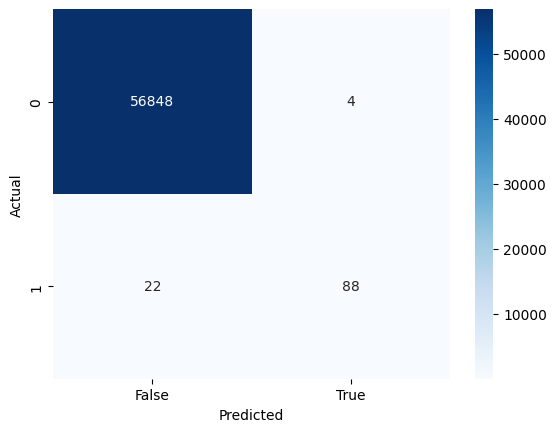

In [59]:
import seaborn as sns
confusion_matrix = pd.crosstab(y_test.values.T, y_pred.values.T, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')